# Kuramoto Synchrobiology Playground

Based on https://github.com/fabridamicelli/kuramoto

In [ ]:
# Some dependencies you might need...
!pip install jupyterplot python-osc networkx

In [1]:
import asyncio
from time import time
import traceback
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from jupyterplot import ProgressPlot
from scipy import integrate
from pythonosc.udp_client import SimpleUDPClient

In [2]:
# Integration using Euler's method
def euler_integrate(dXfunc, X0, t, sim):
    h = t[1] - t[0]
    print(f"Integrating with h={h} (found h={sim.h} in sim)")
    res = [X0]
    for tv in t:
        # Do one Euler integration step for each time step...
        # https://personal.math.ubc.ca/~pwalls/math-python/differential-equations/first-order/
        X0 = X0 + h * dXfunc(X0, tv, sim)
        res.append(X0)
    return np.array(res[:-1])
    
def plot_timeseries(series, figsize=(10,4), xlabel='X', ylabel='Y'):
    _, ax = plt.subplots(figsize=figsize)
    ax.plot(series)
    ax.set_xlabel(xlabel, fontsize=25)
    ax.set_ylabel(ylabel, fontsize=25)
    return ax

def phase_coherence(angles_vec):
        '''
        Compute global order parameter R_t - mean length of resultant phase vector
        '''
        suma = sum([(np.e ** (1j * i)) for i in angles_vec])
        return abs(suma / len(angles_vec))

def plot_coherence(series, figsize=(10,4)):
    _, ax = plt.subplots(figsize=figsize)
    ax.plot([phase_coherence(vec) for vec in series], 'o')
    ax.set_ylabel('Synchronicity / Order', fontsize=16)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylim((-0.01, 1.01))
    return ax


# REALTIME SIMULATION FUNCTIONS...

# Main simulation coroutine
async def sim_task(sim):
    """
    Entry point for Simulation process.
    """
    if sim.send_osc:
        if sim.osc_client is not None:
            del sim.osc_client
            sim.osc_client=None
        sim.osc_client = SimpleUDPClient(sim.osc_dest_addr, sim.osc_dest_port)
        sim.osc_client.send_message(sim.osc_msg_address, ["volume", 1.0]); #unmute sonification
    
    print("Starting Simulation...")
    sim.step=0

    # TODO: Add option to run for N steps
    while sim.run: # A single simulation Step
        timestamp = time()
        
        # Do one Euler step
        # https://personal.math.ubc.ca/~pwalls/math-python/differential-equations/first-order/
        sim.dX = sim.dXfunc(sim.X, sim.t, sim)
        sim.X = sim.X + sim.h * sim.dX
        sim.t += sim.h

        if sim.step % sim.timesteps_per_message == 0:
            
            osc_parcel = ["sim", sim.name, "t", sim.t]        
            osc_parcel.append("X"); osc_parcel.append(sim.X.tolist());
            osc_parcel.append("dX"); osc_parcel.append(sim.dX.tolist());
            
            if sim.send_osc:
                sim.osc_client.send_message(sim.osc_msg_address, osc_parcel)
                
            if sim.realtime_plot is not None:
                sim.realtime_plot.update([np.sin(sim.X).tolist()])

            if sim.print != False:
                if sim.step % sim.print_every == 0:
                    print(osc_parcel)
            
            await asyncio.sleep(sim.message_rate) # scheduler tick

        sim.t += sim.h
        sim.step += 1

    # Resource cleanup...
    print("Ending Simulation")
    if sim.osc_client is not None:
        sim.osc_client.send_message(sim.osc_msg_address, ["volume", 0.0]); #mute sonification
        del sim.osc_client
        sim.osc_client=None
    if sim.realtime_plot is not None:
        sim.realtime_plot.finalize()
        sim.realtime_plot = None

def run_sim(sim, plot=False, plt_height=500, plt_width=800, osc=True, print_output=False, print_every=1000):
    '''
    Run a real-time simulation.
    '''

    sim.run = True
    sim.send_osc = osc
    sim.print = print_output
    sim.print_every = print_every
    
    if plot:
        if sim.realtime_plot is not None:
            sim.realtime_plot.finalize()
            sim.realtime_plot = None
        line_names = [str(x) for x in range(len(sim.X0))]
        sim.realtime_plot = ProgressPlot(line_names=line_names, y_lim=[-1.0, 1.0], width=plt_width, height=plt_height)
        
    sim.X = sim.X0
    sim.t = 0
    
    try:
        loop=asyncio.get_event_loop()
        task=loop.create_task(sim_task(sim))
        print("Simulation Running...")
    except KeyboardInterrupt as e:
        exp = traceback.format_exc()
        raise e
    except Exception as e:
        exp = traceback.format_exc()
        print("Exit with Errors")
        raise e
    finally:
        # Do any necessary cleanup....
        print("Cleanup")

def stop_sim(sim):
    sim.run = False


# Basic Kuramoto System
The Kuramoto model is used to study a wide range of systems with synchronization behaviour. It is a system of N coupled periodic oscillators. Each oscillator has its own constant _"natural frequency"_ $\omega_i$ which it wants to maintain (this is the oscillator's preferred angular velocity). Usually, the distribution of natural frequencies is choosen to be a gaussian-like symmetric function. Usually, a random initial (angular) position $\theta_i$ is assigned to each oscillator. 

The state (position) $\theta_i$ of oscillator $i$ is governed by the following differential equation:

$
\frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i)
$

Where $K$ is the global coupling parameter and $M_i$ is a normalization factor (the number of oscillators interacting with oscillator $i$). $A$ is the adjacency matrix enconding the oscillator connections - typically binary and undirected (symmetric), such that if $i$ interacts with node $j$, then $A_{ij} = 1, otherwise 0$. The basic idea is that, given two oscillators, the one running ahead is encouraged to slow down while the one running behind to accelerate from their preferred angular velocity.

The classical set up has all nodes interacting with each other (all-to-all: a fully connected graph) - and therefore $M_i = N$. In any other case, $M_i$ is the number of nodes connected to node $i$.

See the [Ride My Kuramotocycle](https://www.complexity-explorables.org/explorables/ride-my-kuramotocycle/) applet at complexity-explorables.org for an interactive demonstration of a Kuramoto simulation. And [this MSc thesis](https://go.owu.edu/~physics/StudentResearch/2005/BryanDaniels/kuramoto_paper.pdf) for a more detailed treatment of the basic model.

In [3]:
# Set up simulation
sim = type('KuramotoBasic', (), {})()
sim.name = "KuramotoBasic"
sim.h = 0.001 # integration time step
sim.t = 0.

# Realtime sim / Plotting & OSC Message sending parameters
sim.send_osc = True
sim.osc_msg_address = "/python"
sim.osc_dest_addr = "localhost"
sim.osc_dest_port = 57120 # default OSC port of SuperCollider application
sim.osc_client = None
sim.message_rate = 0.1             # 10fps - delay between updates (OSC & graph) in seconds
sim.timesteps_per_message = 10     # number of integration time steps calculated per update
sim.print=False                    # print output to the jupyter notebook
sim.print_every=1000               # print output to the jupyter notebook every 1000 time steps 
sim.realtime_plot = None

def kuramoto_derivative(X, t, sim):
    '''
        Compute derivative (dtheta_i/dt) of all nodes at current state.
        Where:
            X: vector of current positions (angles theta) size N=number of nodes
            t: current time (this is an autonomous system, does not vary with t)
            sim: simulation parameters and current state
    '''
    assert len(X) == len(sim.natural_frequencies) == len(sim.connectivity_matrix), 'Input dimensions do not match, check lengths'

    angles_i, angles_j = np.meshgrid(X, X)
    interactions = sim.connectivity_matrix * np.sin(angles_j - angles_i)  # Aij * sin(j-i)
    dXdt = sim.natural_frequencies + sim.k_coupling * interactions.sum(axis=0)  # sum over incoming interactions
    return dXdt

sim.dXfunc = kuramoto_derivative

In [4]:
# Kuramoto simulation parameters
sim.k_coupling = 0.12    # global coupling constant K, typical values 0.1-2.0 ... usually phase shift at 0.15
sim.n_nodes = 20        # number of oscillators
sim.natural_frequencies = np.random.normal(size=sim.n_nodes)  # normal distribution of natural frequencies omega
sim.connectivity = 1.   # p=1. = 100% fully connected network
fc_graph = nx.erdos_renyi_graph(n=sim.n_nodes, p=sim.connectivity)
sim.connectivity_matrix = nx.to_numpy_array(fc_graph)         # connectivity matrix p=1. fully connected
sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)       # initial positions theta

# Momentary position & velocity
sim.X = sim.X0
sim.dX = np.array([])
tmax = 25.               # simulation length in seconds

(25000, 20) (25000,) (20,)


<AxesSubplot:xlabel='Time', ylabel='$\\sin(\\theta)$'>

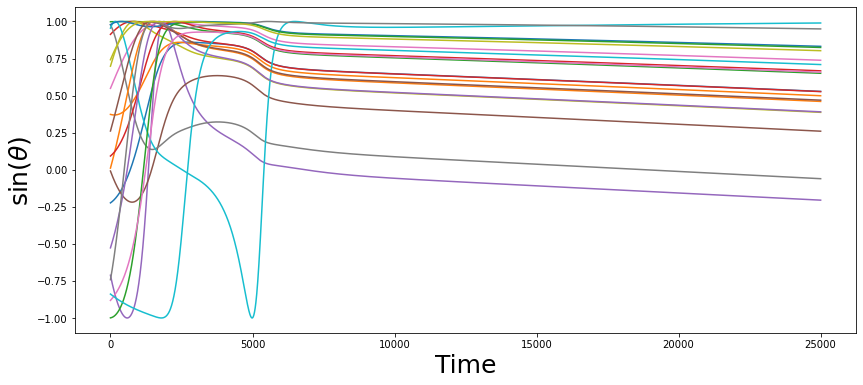

In [5]:
# Plot the results using scipy.integrate.odeint
t = np.arange(0., tmax, step=sim.h)
res_ode = integrate.odeint(sim.dXfunc, sim.X0, t, args=(sim,))
print(res_ode.shape, t.shape, sim.X.shape)
plot_timeseries(np.sin(res_ode), figsize=(14,6), xlabel='Time', ylabel=r'$\sin(\theta)$')

Integrating with h=0.001 (found h=0.001 in sim)
(25000, 20) (25000,) (20,)


<AxesSubplot:xlabel='Time', ylabel='$\\sin(\\theta)$'>

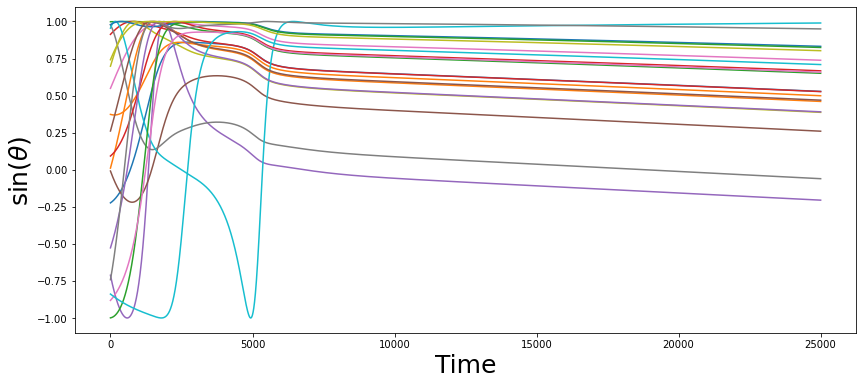

In [6]:
# Computer and plot using Euler Method with timestep sim.h 
#     Compare this against the results from scipy.integrate to make sure our h is small enough
#     to capture the curviness of the trajectories.
t = np.arange(0., tmax, step=sim.h)
res_eul = euler_integrate(sim.dXfunc, sim.X0, t, sim)
print(res_eul.shape, t.shape, sim.X.shape)
plot_timeseries(np.sin(res_eul), figsize=(14,6), xlabel='Time', ylabel=r'$\sin(\theta)$')

<AxesSubplot:xlabel='Time', ylabel='Synchronicity / Order'>

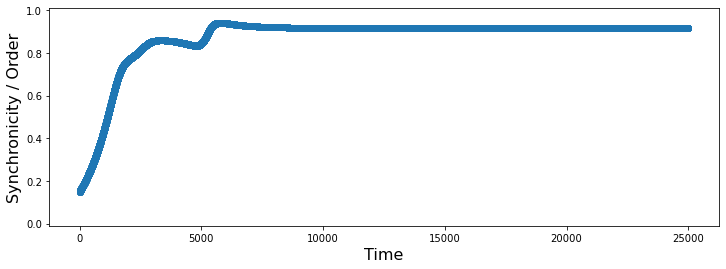

In [7]:
# Plot phase coherence (a measure of synchrony) over time for the entire series
plot_coherence(res_ode, figsize=(12,4))

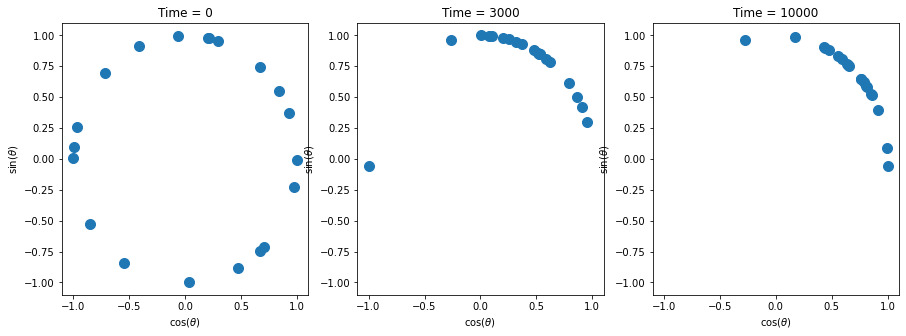

In [8]:
# Plot oscillator positions in the complex plane at times t = 0, 1000, 3000
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5),
                         subplot_kw={
                             "ylim": (-1.1, 1.1),
                             "xlim": (-1.1, 1.1),
                             "xlabel": r'$\cos(\theta)$',
                             "ylabel": r'$\sin(\theta)$',
                         })

time_vals = [0, 3000, 10000]
tseries = res_ode.T
for ax, timeval in zip(axes, time_vals):
    ax.plot(np.cos(tseries[:, timeval]),
            np.sin(tseries[:, timeval]),
            'o',
            markersize=10)
    ax.set_title(f'Time = {timeval}')

# Real-time Simulation

The simulation runs indefinitely in an async coroutine `sim_task()` and therefore will not block the jupyter notebook runtime. To stop the simulation, set `run_simulation` to `False`.

In [9]:
# Randomize initial positions
sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)
sim.X = sim.X0

In [10]:
# Run simulation with realtime plot...
run_sim(sim, plot=True, plt_height=500, plt_width=900, osc=True, print_output=False)

Simulation Running...
Cleanup
Starting Simulation...


Change Parameters while the Simulation is Running

In [13]:
sim.natural_frequencies = np.random.normal(size=sim.n_nodes) # Randomize natural frequencies

In [22]:
sim.connectivity = 0.9 # # Change graph connection density
fc_graph = nx.erdos_renyi_graph(n=sim.n_nodes, p=sim.connectivity)
sim.connectivity_matrix = nx.to_numpy_array(fc_graph)

In [23]:
sim.k_coupling = 0.2    # oscillator coupling
sim.message_rate = 0.1             # update speed
sim.timesteps_per_message = 55    # integration time steps per update

In [26]:
stop_sim(sim) # stop simulation

# Modifications to Basic Kuramoto

During our workdays together we discussed a number of possible modifications that could be made to the basic Kuramoto model: 

$
\frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i)
$


## 1. Adding a driving force (heartbeat) and/or noise parameter

Additional terms could be added to the basic model equation to either drive the model (using the heart beat) or add noise (making dynamics less stable).

$
\frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i) + noise(t) + heartbeat(t)
$

* [Noise-induced synchronization in the Kuramoto model (2020)](https://arxiv.org/abs/2004.00294)


## 2. Variations in Network Topology

Using network topologies of less densely connected and more densely connected areas to describe an entire world, or subsets of the world, and subsets of subsets. For example a sentinel could be considered as a small community of highly connected oscillators.

The entire world of sentinels, microbiota, microplastics and even more could be considered one gigantic interconnected systems of oscillators - with the connectivity of the network shifting and changing according to proximity as the sentinels, microbiota and microplastics move about. Most likely, we could consider the sentinels as a kind of "super hub" with high connectivity within a range around them that tapers off with distance.

![img/network-topologies.png](img/network-topologies.png)
![img/network-topo.png](img/network-topo.png)






## 3. Modifications to Connectivity Matrix

There are a number of simple modifications we could make to the connectivity matrix $A$ to make the system more versatile and to represent different scenarios in the world. 

* Use continuous values rather than binary (on/off) connection strengths. This would allow us to specify some agents to have a "weak" connection and some to have a "strong" connection. Alessio suggests making connection strength a set of quantized values to make analysis easier. For example, four connection strengths: "strong" / "medium" / "weak" / "none"
* Use negative connection values, so that certain oscillators actually repel each other rather than try to synchronize.

We also considered expanding the model to allow for asymmetric coupling matrix $K$ such that it is possible for: 

$
K_{ij} \ne K_{ji}
$

In this model $K$ effectively combines the function of $K$ and $A$ into a single term: 

$
\frac{d \theta_i}{dt} = \omega_i + \frac{1}{M_i} \sum_{j} K_{ij} sin(\theta_j - \theta_i)
$

In this situation, two oscillators can interact but not have a reciprocal influence on each other. Such an extension would allow, for example, to have a microplastic exert a strong influence to synchronize on an organic agent, but have the organic agent exert little or no influence for the microplastic to change.

Such a modification would also make it possible to introduce the heart beat of the visitor as a unique oscillator that interacts with all or many of the agents in the world without being influenced by them in return. This is an alternative approach to the idea of the heart beat be a driving force term.


* [Kuramoto model with oriented, weighted and signed interactions](https://arxiv.org/abs/1807.11410)

## 4. Choice of Natural Frequencies & Initial Conditions
Not only a gaussian distribution, but maybe natural frequency and initial conditions are more meaningful - related in an important way to the world and its nature.

## 5. Metastability and Chimera States

Studying modifications to the Kuramoto model that promote metastability and chimera states is probably of use to us, because we are looking to create systems with interesting dynamics that could easily be pushed into different states and display ecological behaviors such as flickering and tipping points.

The most influential paper exploring this topic is Shanahan (2009), which proposes adding a phase lag parameter  $\alpha$ to the equation. Francesca suggests that this lag parameter could also, like the noise term, be time-dependent.

$
\frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i - \alpha)
$



* [Metastable Chimera States in Community-Structured Oscillator Networks (2009)](https://arxiv.org/abs/0908.3881)
* [Earthquake sequencing: chimera states with Kuramoto model dynamics on directed graphs (2015)](https://npg.copernicus.org/articles/22/499/2015/)
* [Higher-order interactions promote chimera states (2022)](https://arxiv.org/abs/2204.00037)



## 6. Variations on Oscillator Behavior

The oscillators don't need to just have a fixed frequency. Some suggestions have been made to give them more interesting behavior. For example: a 2021 paper suggests having "run and tumble" oscillation, where the angular velocity moves in fits and starts. 

* [Kuramoto model with run-and-tumble dynamics (2021)](https://arxiv.org/abs/2108.00124)

Another paper suggests adding inertia to the Kuramoto model. The inertia model has been used to successfully model the synchronization of fireflies.

* [Kuramoto oscillators under the effect of inertia (2017)](https://arxiv.org/abs/1712.10111)

_Second-order Kuramoto Model with Inertia_

$
m \frac{d^2 \theta_i}{dt^2} + \frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i)
$





## 7. Memory and Learning

Sissel and Alessio discussed adding elements of memory and learning to the coupling between oscillators, such that if agents have been in sychronicity in the past then it might be easier or more difficult for them to form connections in the future. 

* [A Kuramoto Model with Inertia and Hebbian Learning (2022)](https://arxiv.org/abs/2203.12090)

## 8. Metaparameters

Measurements of synchronicity, asynchronicity, metastability, chimera states and more... would be useful to be able to get simpler, low-dimensional values that give us an idea of how the world and sub-communities within the world are behaving. For example, we have a "phase coherence" metric in the basic model above. The paper on chimera states also proposes some metrics for metastability.


* [Using Machine Learning to understand Kuramoto systems (2021)](https://arxiv.org/abs/2109.08918)

# Population Dynamics

Our discussion with Jacopo revealed some important considerations for the population dynamics of the world.
Especially questions like:

* what population rules govern the lives of microbiota in the world?
* to what extent and how do microplastics have an influence on microbiota?

There are a few key features needed for a population dynamics model to govern the agent populations in the world (sentinel + microbiota + microplastic)

* How individuals are born (how are sentinels born? how are microbiota born? how are microplastics born?)
    * by giving birth (two+ individuals meet and create new ones), by splitting (single individual splits into many), shedding? etc...
* How individuals die (for sentinels, their frequency drops below a certain level - they become fossilized)
* How they merge (creating new assemblages - governed by synchronicity)


## Flow of influence from sentinel to microplastic to microbiota

We discussed one possible model, whereby a constant population of microbiota are maintained in the world (when a sentinel absorbs one species, a new one is born somewhere in the world). Sentinels are born whenever somebody plugs in to the installation, and survive afterwards with their visitor's heartbeat - but tend towards fossilization moreso than if they had an active heartbeat driving them. 

In this model, Sentinels exert a strong synchronic influence on the world in a wide proximity (on the scale of a whole ecological sub-zone) - effecting the time scales of microbiota and environment in those areas. Microplastic monuments have a similar wide-influence of connectivity, but only effect sentinels. The microbiota are effected by the microplastics *through* the sentinels.

